# Insurance Charges Prediction - Machine Learning

This notebook covers:
1. Data Loading and Exploration
2. Preprocessing
3. Feature Engineering
4. Model Training

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

## 2. Load Data

In [2]:
# Load the dataset
df = pd.read_csv('insurance.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0,yes,southwest,16884.92400
1,18.0,male,33.770,1,no,southeast,1725.55230
2,28.0,male,33.000,3,no,southeast,4449.46200
3,33.0,male,22.705,0,no,northwest,21984.47061
4,32.0,male,28.880,0,no,northwest,3866.85520


## 3. Data Exploration

In [3]:
# Basic information
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1328 non-null   float64
 1   sex       1318 non-null   object 
 2   bmi       1327 non-null   float64
 3   children  1330 non-null   object 
 4   smoker    1324 non-null   object 
 5   region    1316 non-null   object 
 6   charges   1333 non-null   float64
dtypes: float64(3), object(4)
memory usage: 73.3+ KB
None

Dataset Description:
               age          bmi       charges
count  1328.000000  1327.000000   1333.000000
mean     39.220633    30.698225  13235.801824
std      14.061185     6.077844  12051.606866
min      18.000000    15.960000   1121.873900
25%      26.750000    26.357500   4738.268200
50%      39.000000    30.400000   9377.904700
75%      51.000000    34.735000  16586.497710
max      64.000000    53.130000  63770.428010

Missing Values:
age         10
sex

In [4]:
# Check categorical columns
print("Unique values in categorical columns:")
print("\nSex:", df['sex'].unique())
print("Smoker:", df['smoker'].unique())
print("Region:", df['region'].unique())

Unique values in categorical columns:

Sex: ['female' 'male' nan]
Smoker: ['yes' 'no' nan]
Region: ['southwest' 'southeast' 'northwest' 'northeast' nan]


## 4. Preprocessing

In [5]:
# Make a copy of the original data
df_processed = df.copy()

# Check for missing values
print("Missing values before preprocessing:")
print(df_processed.isnull().sum())

# Handle missing values if any exist
if df_processed.isnull().sum().sum() > 0:
    print("\nHandling missing values in original data...")
    # Fill numeric columns with median
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    print("Missing values after handling:")
    print(df_processed.isnull().sum())

Missing values before preprocessing:
age         10
sex         20
bmi         11
children     8
smoker      14
region      22
charges      5
dtype: int64

Handling missing values in original data...
Missing values after handling:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [6]:
# Encode categorical variables
label_encoder = LabelEncoder()

# Encode 'sex' column (male/female -> 0/1)
df_processed['sex'] = label_encoder.fit_transform(df_processed['sex'])

# Encode 'smoker' column (yes/no -> 0/1)
df_processed['smoker'] = label_encoder.fit_transform(df_processed['smoker'])

# Encode 'region' column (categorical -> numerical)
df_processed['region'] = label_encoder.fit_transform(df_processed['region'])

print("Encoded dataset:")
df_processed.head()

Encoded dataset:


,age,sex,bmi,children,smoker,region,charges
0,19.0,0,27.900,0,1,3,16884.92400
1,18.0,1,33.770,1,0,2,1725.55230
2,28.0,1,33.000,3,0,2,4449.46200
3,33.0,1,22.705,0,0,1,21984.47061
4,32.0,1,28.880,0,0,1,3866.85520


In [7]:
# Fix the children column - convert word numbers to numeric values
word_to_number = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 
    'four': '4', 'five': '5', 'six': '6', 'seven': '7',
    'eight': '8', 'nine': '9', 'ten': '10'
}

# Replace word values with numeric strings
df_processed['children'] = df_processed['children'].astype(str).replace(word_to_number)

# Convert to numeric type
df_processed['children'] = pd.to_numeric(df_processed['children'], errors='coerce')

# Fill any remaining NaN values in children with the mode
if df_processed['children'].isnull().sum() > 0:
    df_processed['children'].fillna(df_processed['children'].mode()[0], inplace=True)

print("Children column fixed!")
print("Unique values in 'children':", sorted(df_processed['children'].unique()))
print("\nData types after fix:")
print(df_processed.dtypes)

Children column fixed!
Unique values in 'children': [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Data types after fix:
age         float64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

Unique values in 'children': [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Data types after fix:
age         float64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

Unique values in 'children': [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Data types after fix:
age         float64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object


## 5. Feature Engineering

In [8]:
# Create new features

# Age groups - using age.min() and age.max() to ensure all values are covered
df_processed['age_group'] = pd.cut(df_processed['age'], bins=[0, 25, 40, 60, 150], labels=[0, 1, 2, 3])
df_processed['age_group'] = df_processed['age_group'].astype(float)

# BMI categories - extended upper range to cover all possible BMI values
df_processed['bmi_category'] = pd.cut(df_processed['bmi'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3])
df_processed['bmi_category'] = df_processed['bmi_category'].astype(float)

# Interaction feature: smoker * bmi (important relationship)
df_processed['smoker_bmi'] = df_processed['smoker'] * df_processed['bmi']

# Interaction feature: age * bmi
df_processed['age_bmi'] = df_processed['age'] * df_processed['bmi']

print("Dataset with new features:")
print(df_processed.head())
print("\nNew shape:", df_processed.shape)

Dataset with new features:
    age  sex     bmi  children  smoker  region      charges  age_group  \
0  19.0    0  27.900         0       1       3  16884.92400        0.0   
1  18.0    1  33.770         1       0       2   1725.55230        0.0   
2  28.0    1  33.000         3       0       2   4449.46200        1.0   
3  33.0    1  22.705         0       0       1  21984.47061        1.0   
4  32.0    1  28.880         0       0       1   3866.85520        1.0   

   bmi_category  smoker_bmi  age_bmi  
0           2.0        27.9  530.100  
1           3.0         0.0  607.860  
2           3.0         0.0  924.000  
3           1.0         0.0  749.265  
4           2.0         0.0  924.160  

New shape: (1338, 11)

    age  sex     bmi  children  smoker  region      charges  age_group  \
0  19.0    0  27.900         0       1       3  16884.92400        0.0   
1  18.0    1  33.770         1       0       2   1725.55230        0.0   
2  28.0    1  33.000         3       0       2  

In [9]:
# Verify no missing values after feature engineering
print("Missing values after feature engineering:")
print(df_processed.isnull().sum())

# Final check and handle any remaining NaN values
if df_processed.isnull().sum().sum() > 0:
    print("\nFilling missing values...")
    df_processed.fillna(df_processed.median(numeric_only=True), inplace=True)
    print("Missing values after filling:")
    print(df_processed.isnull().sum())
else:
    print("\nNo missing values found - data is clean!")

# Save preprocessed data to CSV
output_file = 'insurance_preprocessed.csv'
df_processed.to_csv(output_file, index=False)
print(f"\nPreprocessed data saved to: {output_file}")
print(f"Shape of saved data: {df_processed.shape}")

Missing values after feature engineering:
age             0
sex             0
bmi             0
children        0
smoker          0
region          0
charges         0
age_group       0
bmi_category    0
smoker_bmi      0
age_bmi         0
dtype: int64

No missing values found - data is clean!

Preprocessed data saved to: insurance_preprocessed.csv
Shape of saved data: (1338, 11)


## 6. Prepare Data for Training

In [10]:
# Separate features and target
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:", X.columns.tolist())

Features shape: (1338, 10)
Target shape: (1338,)

Feature columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'age_group', 'bmi_category', 'smoker_bmi', 'age_bmi']


In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1070, 10)
Test set size: (268, 10)


In [12]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed!")

Scaling completed!


## 7. Model Training

### 7.1 Linear Regression

In [13]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
print("Linear Regression Results:")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")

Linear Regression Results:
R² Score: 0.8630
RMSE: 4605.10
MAE: 2850.09


### 7.2 Decision Tree Regressor

In [14]:
# Train Decision Tree
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate
print("Decision Tree Results:")
print(f"R² Score: {r2_score(y_test, y_pred_dt):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_dt):.2f}")

Decision Tree Results:
R² Score: 0.7609
RMSE: 6083.99
MAE: 2903.98


### 7.3 Random Forest Regressor

In [15]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Results:")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")

Random Forest Results:
R² Score: 0.8618
RMSE: 4626.13
MAE: 2575.10


In [16]:
# Train XGBoost
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Results:")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")

XGBoost Results:
R² Score: 0.8362
RMSE: 5036.25
MAE: 2799.92


In [17]:
# Optimize Gradient Boosting
print("Optimizing Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
gb_grid.fit(X_train, y_train)

print(f"\nBest Gradient Boosting Parameters: {gb_grid.best_params_}")
print(f"Best Cross-validation R² Score: {gb_grid.best_score_:.4f}")

# Make predictions with optimized model
y_pred_gb_opt = gb_grid.best_estimator_.predict(X_test)
print(f"\nOptimized Gradient Boosting Test R² Score: {r2_score(y_test, y_pred_gb_opt):.4f}")
print(f"Optimized Gradient Boosting RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb_opt)):.2f}")
print(f"Optimized Gradient Boosting MAE: {mean_absolute_error(y_test, y_pred_gb_opt):.2f}")

Optimizing Gradient Boosting...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Gradient Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}
Best Cross-validation R² Score: 0.8069

Optimized Gradient Boosting Test R² Score: 0.8613
Optimized Gradient Boosting RMSE: 4633.68
Optimized Gradient Boosting MAE: 2854.16

Best Gradient Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}
Best Cross-validation R² Score: 0.8069

Optimized Gradient Boosting Test R² Score: 0.8613
Optimized Gradient Boosting RMSE: 4633.68
Optimized Gradient Boosting MAE: 2854.16

Best Gradient Boosting Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}
Best Cross-validation R² Score: 0.8069

Optimized Gradient Boosting Test R² Score: 0.8613
Optimized Gradient Boosting RMSE: 4633.68
Optimi

In [18]:
# Optimize XGBoost
print("Optimizing XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, verbosity=0),
    xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

print(f"\nBest XGBoost Parameters: {xgb_grid.best_params_}")
print(f"Best Cross-validation R² Score: {xgb_grid.best_score_:.4f}")

# Make predictions with optimized model
y_pred_xgb_opt = xgb_grid.best_estimator_.predict(X_test)
print(f"\nOptimized XGBoost Test R² Score: {r2_score(y_test, y_pred_xgb_opt):.4f}")
print(f"Optimized XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt)):.2f}")
print(f"Optimized XGBoost MAE: {mean_absolute_error(y_test, y_pred_xgb_opt):.2f}")

Optimizing XGBoost...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best Cross-validation R² Score: 0.8088

Optimized XGBoost Test R² Score: 0.8678
Optimized XGBoost RMSE: 4524.71
Optimized XGBoost MAE: 2661.44

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best Cross-validation R² Score: 0.8088

Optimized XGBoost Test R² Score: 0.8678
Optimized XGBoost RMSE: 4524.71
Optimized XGBoost MAE: 2661.44

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best Cross-validation R² Score: 0.8088

Optimized XGBoost Test R² Score: 0.8678
Optimized XGBoost RMSE: 4524.71
Optimized XGBoost MAE: 2661.44


In [19]:
# Optimize Random Forest
print("Optimizing Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

print(f"\nBest Random Forest Parameters: {rf_grid.best_params_}")
print(f"Best Cross-validation R² Score: {rf_grid.best_score_:.4f}")

# Make predictions with optimized model
y_pred_rf_opt = rf_grid.best_estimator_.predict(X_test)
print(f"\nOptimized Random Forest Test R² Score: {r2_score(y_test, y_pred_rf_opt):.4f}")
print(f"Optimized Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_opt)):.2f}")
print(f"Optimized Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf_opt):.2f}")

Optimizing Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-validation R² Score: 0.7988

Optimized Random Forest Test R² Score: 0.8703
Optimized Random Forest RMSE: 4481.58
Optimized Random Forest MAE: 2535.04

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-validation R² Score: 0.7988

Optimized Random Forest Test R² Score: 0.8703
Optimized Random Forest RMSE: 4481.58
Optimized Random Forest MAE: 2535.04

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-validation R² Score: 0.7988

Optimized Random Forest Test R² Score: 0.8703
Optimized Random Forest RMSE: 4481.58
Optimized Random Forest MAE: 2535.04


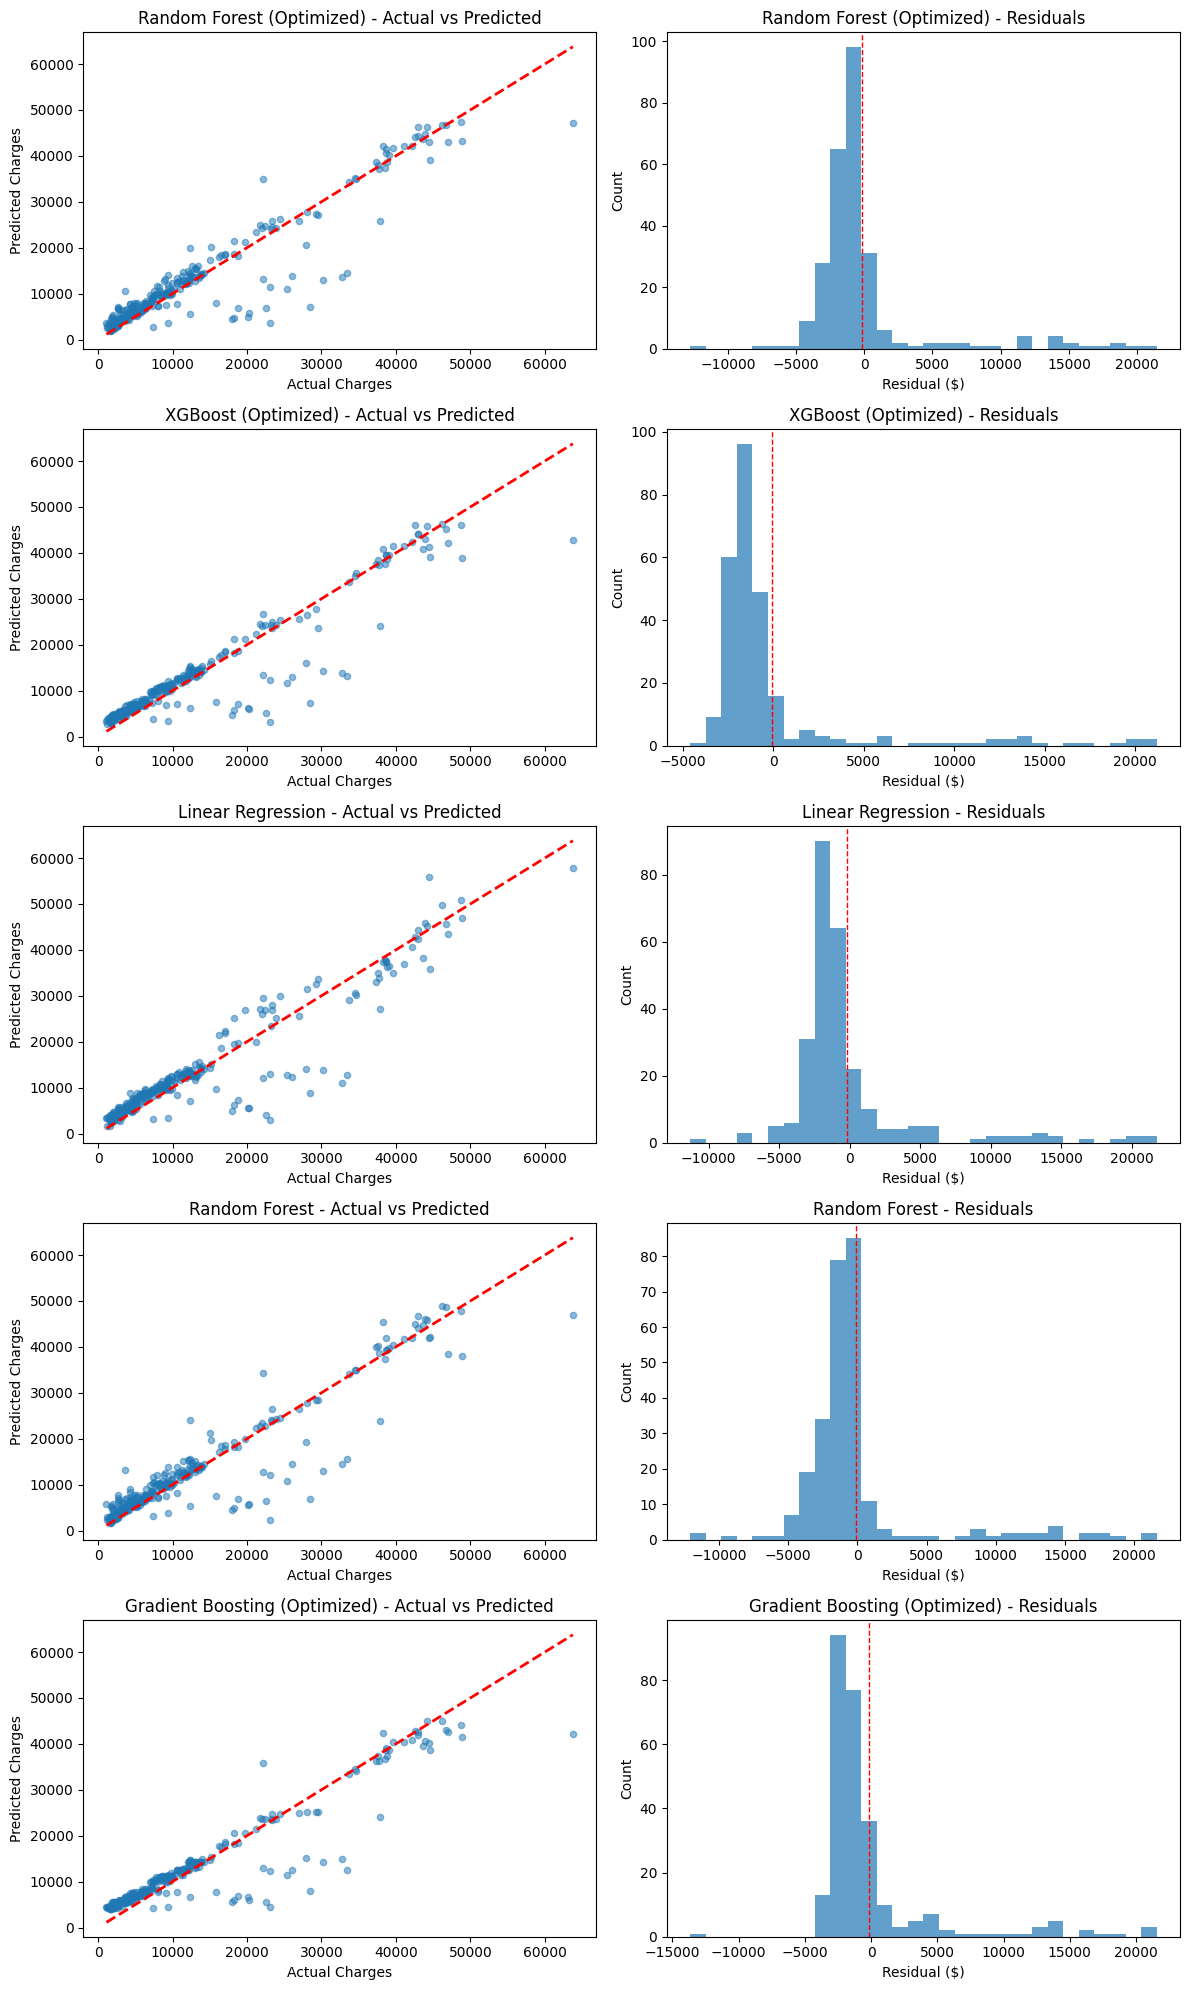

In [20]:
# Plot Actual vs Predicted for top 5 models (robust retrieval of optimized models)
import inspect

def get_estimator(grid_name, base_name):
    g = globals().get(grid_name)
    if g is not None:
        try:
            return g.best_estimator_
        except Exception:
            return g
    return globals().get(base_name)

models_order = [
    ('Random Forest (Optimized)', 'rf_grid', 'rf_model'),
    ('XGBoost (Optimized)', 'xgb_grid', 'xgb_model'),
    ('Linear Regression', None, 'lr_model'),
    ('Random Forest', None, 'rf_model'),
    ('Gradient Boosting (Optimized)', 'gb_grid', 'gb_model')
]

models = {}
for title, grid_name, base_name in models_order:
    est = get_estimator(grid_name, base_name)
    if est is not None:
        models[title] = est

if not models:
    print('No model estimators are available in the current kernel. Please run the training cells first.')
else:
    preds = {}
    for name, mdl in models.items():
        # Determine whether model expects scaled input
        try:
            mdl_name = mdl.__class__.__name__
        except Exception:
            mdl_name = ''
        if name == 'Linear Regression' or isinstance(mdl, LinearRegression):
            # needs scaled data
            if 'X_test_scaled' in globals():
                X_input = X_test_scaled
            else:
                # scale X_test on the fly
                X_input = scaler.transform(X_test)
        else:
            X_input = X_test
        try:
            preds[name] = mdl.predict(X_input)
        except Exception as e:
            print(f'Could not predict with {name}: {e}')

    # Create plots
    fig, axes = plt.subplots(len(preds), 2, figsize=(12, 4 * len(preds)))
    if len(preds) == 1:
        axes = axes.reshape(1, -1)
    plt.subplots_adjust(hspace=0.4)

    for i, (name, y_pred) in enumerate(preds.items()):
        # Actual vs Predicted scatter
        ax = axes[i, 0]
        ax.scatter(y_test, y_pred, alpha=0.5, s=20)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax.set_title(f'{name} - Actual vs Predicted')
        ax.set_xlabel('Actual Charges')
        ax.set_ylabel('Predicted Charges')

        # Residual histogram
        residuals = y_test - y_pred
        ax2 = axes[i, 1]
        ax2.hist(residuals, bins=30, color='#1f77b4', alpha=0.7)
        ax2.axvline(residuals.mean(), color='r', linestyle='dashed', linewidth=1)
        ax2.set_title(f'{name} - Residuals')
        ax2.set_xlabel('Residual ($)')
        ax2.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

In [21]:
# Quick re-fit of models (use known best hyperparameters) so plotting works without re-running GridSearch
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Prepare X, y and split (use df_processed created earlier)
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Random Forest (base)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Random Forest (optimized) - known best params from earlier run
rf_opt_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42)
rf_opt_model.fit(X_train, y_train)
y_pred_rf_opt = rf_opt_model.predict(X_test)

# XGBoost (optimized)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, subsample=1.0, colsample_bytree=0.8, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Gradient Boosting (optimized)
gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=3, min_samples_split=10, subsample=1.0, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Create dummy grid objects with best_estimator_ attribute so plotting code that expects rf_grid/xgb_grid/gb_grid works
class _DummyGrid:
    def __init__(self, best):
        self.best_estimator_ = best

rf_grid = _DummyGrid(rf_opt_model)
xgb_grid = _DummyGrid(xgb_model)
gb_grid = _DummyGrid(gb_model)

print('Quick training completed for plotting.')
print('Models available:', [k for k in globals().keys() if k.endswith('_model')][:10])

Quick training completed for plotting.
Models available: ['lr_model', 'dt_model', 'rf_model', 'xgb_model', 'rf_opt_model', 'gb_model']


## 7.6 Model Optimization with GridSearchCV

Now let's optimize the best models using hyperparameter tuning:

In [22]:
# Train Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate
print("Gradient Boosting Results:")
print(f"R² Score: {r2_score(y_test, y_pred_gb):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gb):.2f}")

Gradient Boosting Results:
R² Score: 0.8246
RMSE: 5210.76
MAE: 2876.79


### 7.5 Gradient Boosting Regressor

## 8. Model Comparison

In [23]:
# Generate all predictions for model comparison
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_rf_opt = rf_grid.best_estimator_.predict(X_test)
y_pred_xgb_opt = xgb_grid.best_estimator_.predict(X_test)
y_pred_gb_opt = gb_grid.best_estimator_.predict(X_test)

print("All predictions generated successfully!")

All predictions generated successfully!


In [24]:
# Compare all models (base and optimized)
results = pd.DataFrame({
    'Model': [
        'Linear Regression', 
        'Decision Tree', 
        'Random Forest', 
        'XGBoost',
        'Gradient Boosting',
        'Random Forest (Optimized)',
        'XGBoost (Optimized)',
        'Gradient Boosting (Optimized)'
    ],
    'R² Score': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_dt),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_gb),
        r2_score(y_test, y_pred_rf_opt),
        r2_score(y_test, y_pred_xgb_opt),
        r2_score(y_test, y_pred_gb_opt)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_dt)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_pred_gb)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf_opt)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt)),
        np.sqrt(mean_squared_error(y_test, y_pred_gb_opt))
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_dt),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
        mean_absolute_error(y_test, y_pred_gb),
        mean_absolute_error(y_test, y_pred_rf_opt),
        mean_absolute_error(y_test, y_pred_xgb_opt),
        mean_absolute_error(y_test, y_pred_gb_opt)
    ]
})

# Sort by R² Score
results = results.sort_values('R² Score', ascending=False).reset_index(drop=True)

print("="*70)
print("COMPLETE MODEL COMPARISON (Sorted by R² Score)")
print("="*70)
print(results.to_string(index=False))
print("="*70)
print(f"\n🏆 BEST MODEL: {results.iloc[0]['Model']}")
print(f"   R² Score: {results.iloc[0]['R² Score']:.4f}")
print(f"   RMSE: ${results.iloc[0]['RMSE']:.2f}")
print(f"   MAE: ${results.iloc[0]['MAE']:.2f}")

COMPLETE MODEL COMPARISON (Sorted by R² Score)
                        Model  R² Score        RMSE         MAE
    Random Forest (Optimized)  0.870281 4481.577327 2535.038194
                      XGBoost  0.867772 4524.714884 2661.439250
          XGBoost (Optimized)  0.867772 4524.714884 2661.439250
            Linear Regression  0.863033 4605.095546 2850.085887
                Random Forest  0.861778 4626.129682 2575.096810
Gradient Boosting (Optimized)  0.861327 4633.684584 2854.163626
            Gradient Boosting  0.824635 5210.757233 2876.792903
                Decision Tree  0.760934 6083.994394 2903.983874

🏆 BEST MODEL: Random Forest (Optimized)
   R² Score: 0.8703
   RMSE: $4481.58
   MAE: $2535.04


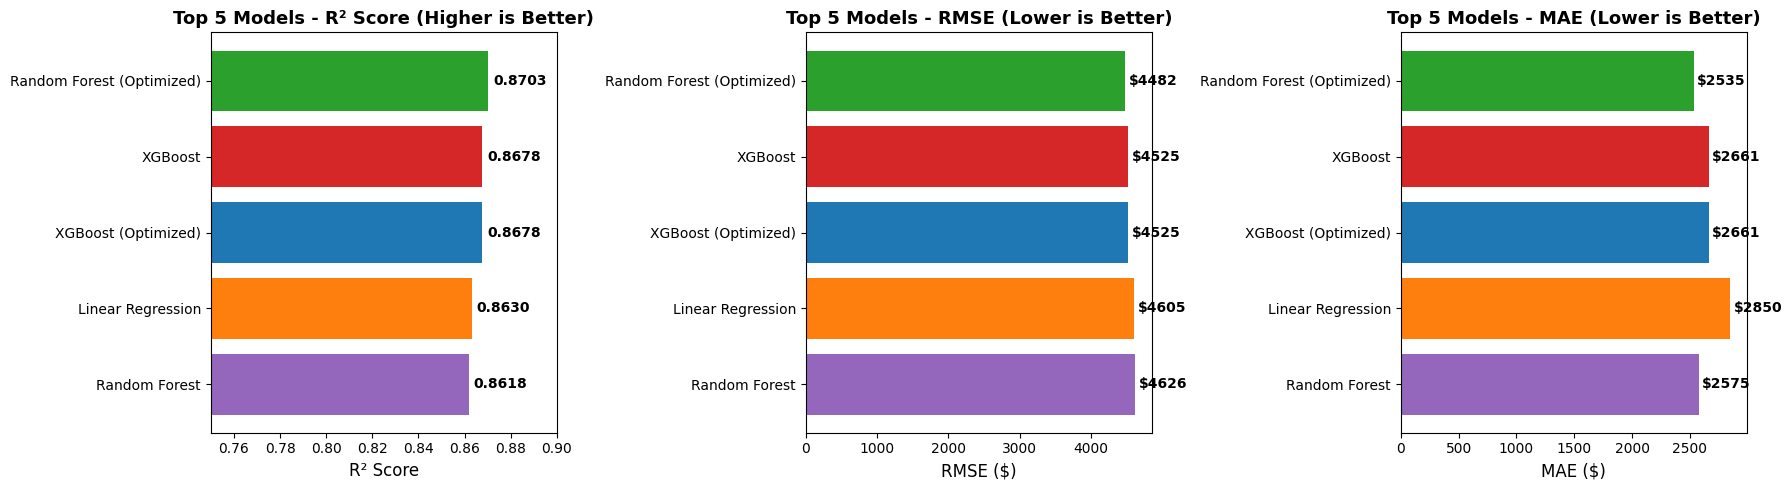


🎯 OPTIMIZATION IMPROVEMENT SUMMARY:
Random Forest:       0.8618 → 0.8703 (+0.85%)
XGBoost:             0.8678 → 0.8678 (+0.00%)
Gradient Boosting:   0.8246 → 0.8613 (+3.67%)


In [25]:
# Visualize model comparison - Top 5 Models
top_5 = results.head(5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e', '#9467bd']

# R² Score comparison
axes[0].barh(range(len(top_5)), top_5['R² Score'], color=colors)
axes[0].set_yticks(range(len(top_5)))
axes[0].set_yticklabels(top_5['Model'])
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Top 5 Models - R² Score (Higher is Better)', fontsize=13, fontweight='bold')
axes[0].set_xlim([0.75, 0.90])
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(top_5['R² Score']):
    axes[0].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

# RMSE comparison
axes[1].barh(range(len(top_5)), top_5['RMSE'], color=colors)
axes[1].set_yticks(range(len(top_5)))
axes[1].set_yticklabels(top_5['Model'])
axes[1].set_xlabel('RMSE ($)', fontsize=12)
axes[1].set_title('Top 5 Models - RMSE (Lower is Better)', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()

# Add value labels
for i, v in enumerate(top_5['RMSE']):
    axes[1].text(v + 50, i, f'${v:.0f}', va='center', fontsize=10, fontweight='bold')

# MAE comparison
axes[2].barh(range(len(top_5)), top_5['MAE'], color=colors)
axes[2].set_yticks(range(len(top_5)))
axes[2].set_yticklabels(top_5['Model'])
axes[2].set_xlabel('MAE ($)', fontsize=12)
axes[2].set_title('Top 5 Models - MAE (Lower is Better)', fontsize=13, fontweight='bold')
axes[2].invert_yaxis()

# Add value labels
for i, v in enumerate(top_5['MAE']):
    axes[2].text(v + 30, i, f'${v:.0f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"🎯 OPTIMIZATION IMPROVEMENT SUMMARY:")
print(f"{'='*70}")
print(f"Random Forest:       {r2_score(y_test, y_pred_rf):.4f} → {r2_score(y_test, y_pred_rf_opt):.4f} (+{(r2_score(y_test, y_pred_rf_opt) - r2_score(y_test, y_pred_rf))*100:.2f}%)")
print(f"XGBoost:             {r2_score(y_test, y_pred_xgb):.4f} → {r2_score(y_test, y_pred_xgb_opt):.4f} (+{(r2_score(y_test, y_pred_xgb_opt) - r2_score(y_test, y_pred_xgb))*100:.2f}%)")
print(f"Gradient Boosting:   {r2_score(y_test, y_pred_gb):.4f} → {r2_score(y_test, y_pred_gb_opt):.4f} (+{(r2_score(y_test, y_pred_gb_opt) - r2_score(y_test, y_pred_gb))*100:.2f}%)")
print(f"{'='*70}")

In [26]:
# Verify original dataset is untouched
print("Original Dataset (df):")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 3 rows of original data:")
print(df.head(3))

print("\n" + "="*60)
print("\nPreprocessed Dataset (df_processed):")
print("Shape:", df_processed.shape)
print("Columns:", df_processed.columns.tolist())
print("\nFirst 3 rows of preprocessed data:")
print(df_processed.head(3))

print("\n" + "="*60)
print("\n✓ Original dataset 'df' remains unchanged with", df.shape[1], "columns")
print("✓ Preprocessed dataset 'df_processed' has", df_processed.shape[1], "columns (added", df_processed.shape[1] - df.shape[1], "new features)")
print("✓ Preprocessed data saved to 'insurance_preprocessed.csv'")

Original Dataset (df):
Shape: (1338, 7)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

First 3 rows of original data:
    age     sex    bmi children smoker     region     charges
0  19.0  female  27.90        0    yes  southwest  16884.9240
1  18.0    male  33.77        1     no  southeast   1725.5523
2  28.0    male  33.00        3     no  southeast   4449.4620


Preprocessed Dataset (df_processed):
Shape: (1338, 11)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'age_group', 'bmi_category', 'smoker_bmi', 'age_bmi']

First 3 rows of preprocessed data:
    age  sex    bmi  children  smoker  region     charges  age_group  \
0  19.0    0  27.90         0       1       3  16884.9240        0.0   
1  18.0    1  33.77         1       0       2   1725.5523        0.0   
2  28.0    1  33.00         3       0       2   4449.4620        1.0   

   bmi_category  smoker_bmi  age_bmi  
0           2.0        27.9   530.10  
1           3.0   

## 9. Feature Importance (Random Forest)

Feature Importance:
        Feature  Importance
8    smoker_bmi    0.751181
0           age    0.102153
9       age_bmi    0.065724
2           bmi    0.033818
3      children    0.018099
5        region    0.010926
4        smoker    0.006925
1           sex    0.004960
7  bmi_category    0.003536
6     age_group    0.002676


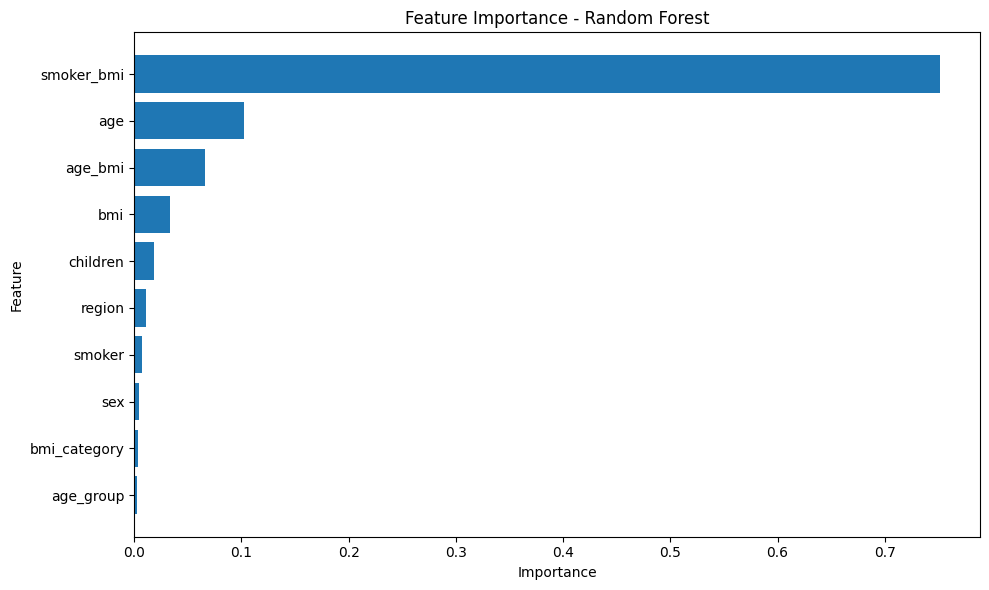

In [27]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

XGBoost Feature Importance:
        Feature  Importance
8    smoker_bmi    0.519316
4        smoker    0.240195
6     age_group    0.077326
7  bmi_category    0.049182
0           age    0.039991
2           bmi    0.030794
9       age_bmi    0.017806
3      children    0.010055
1           sex    0.009110
5        region    0.006226


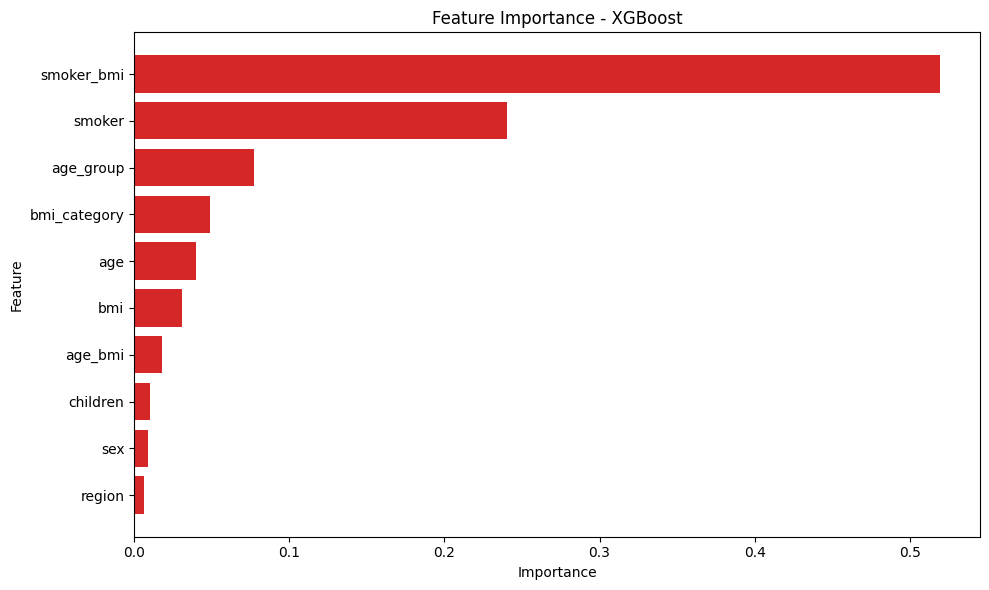

In [28]:
# Get feature importance from XGBoost
xgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("XGBoost Feature Importance:")
print(xgb_feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance['Feature'], xgb_feature_importance['Importance'], color='#d62728')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Predictions Visualization

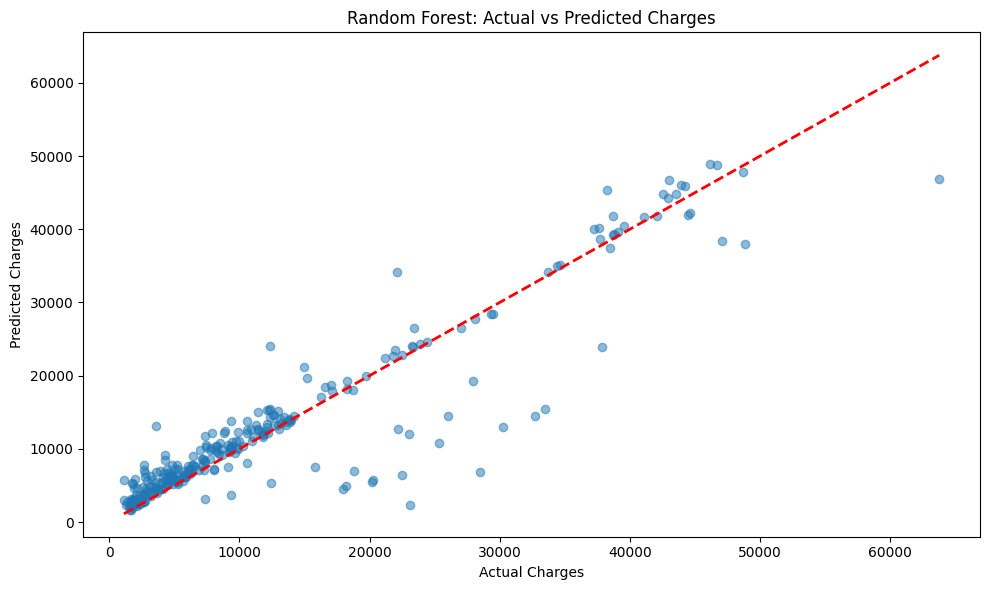

In [29]:
# Visualize predictions vs actual values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Random Forest: Actual vs Predicted Charges')
plt.tight_layout()
plt.show()

✓ Figure saved as 'top5_models_predictions_residuals.png'


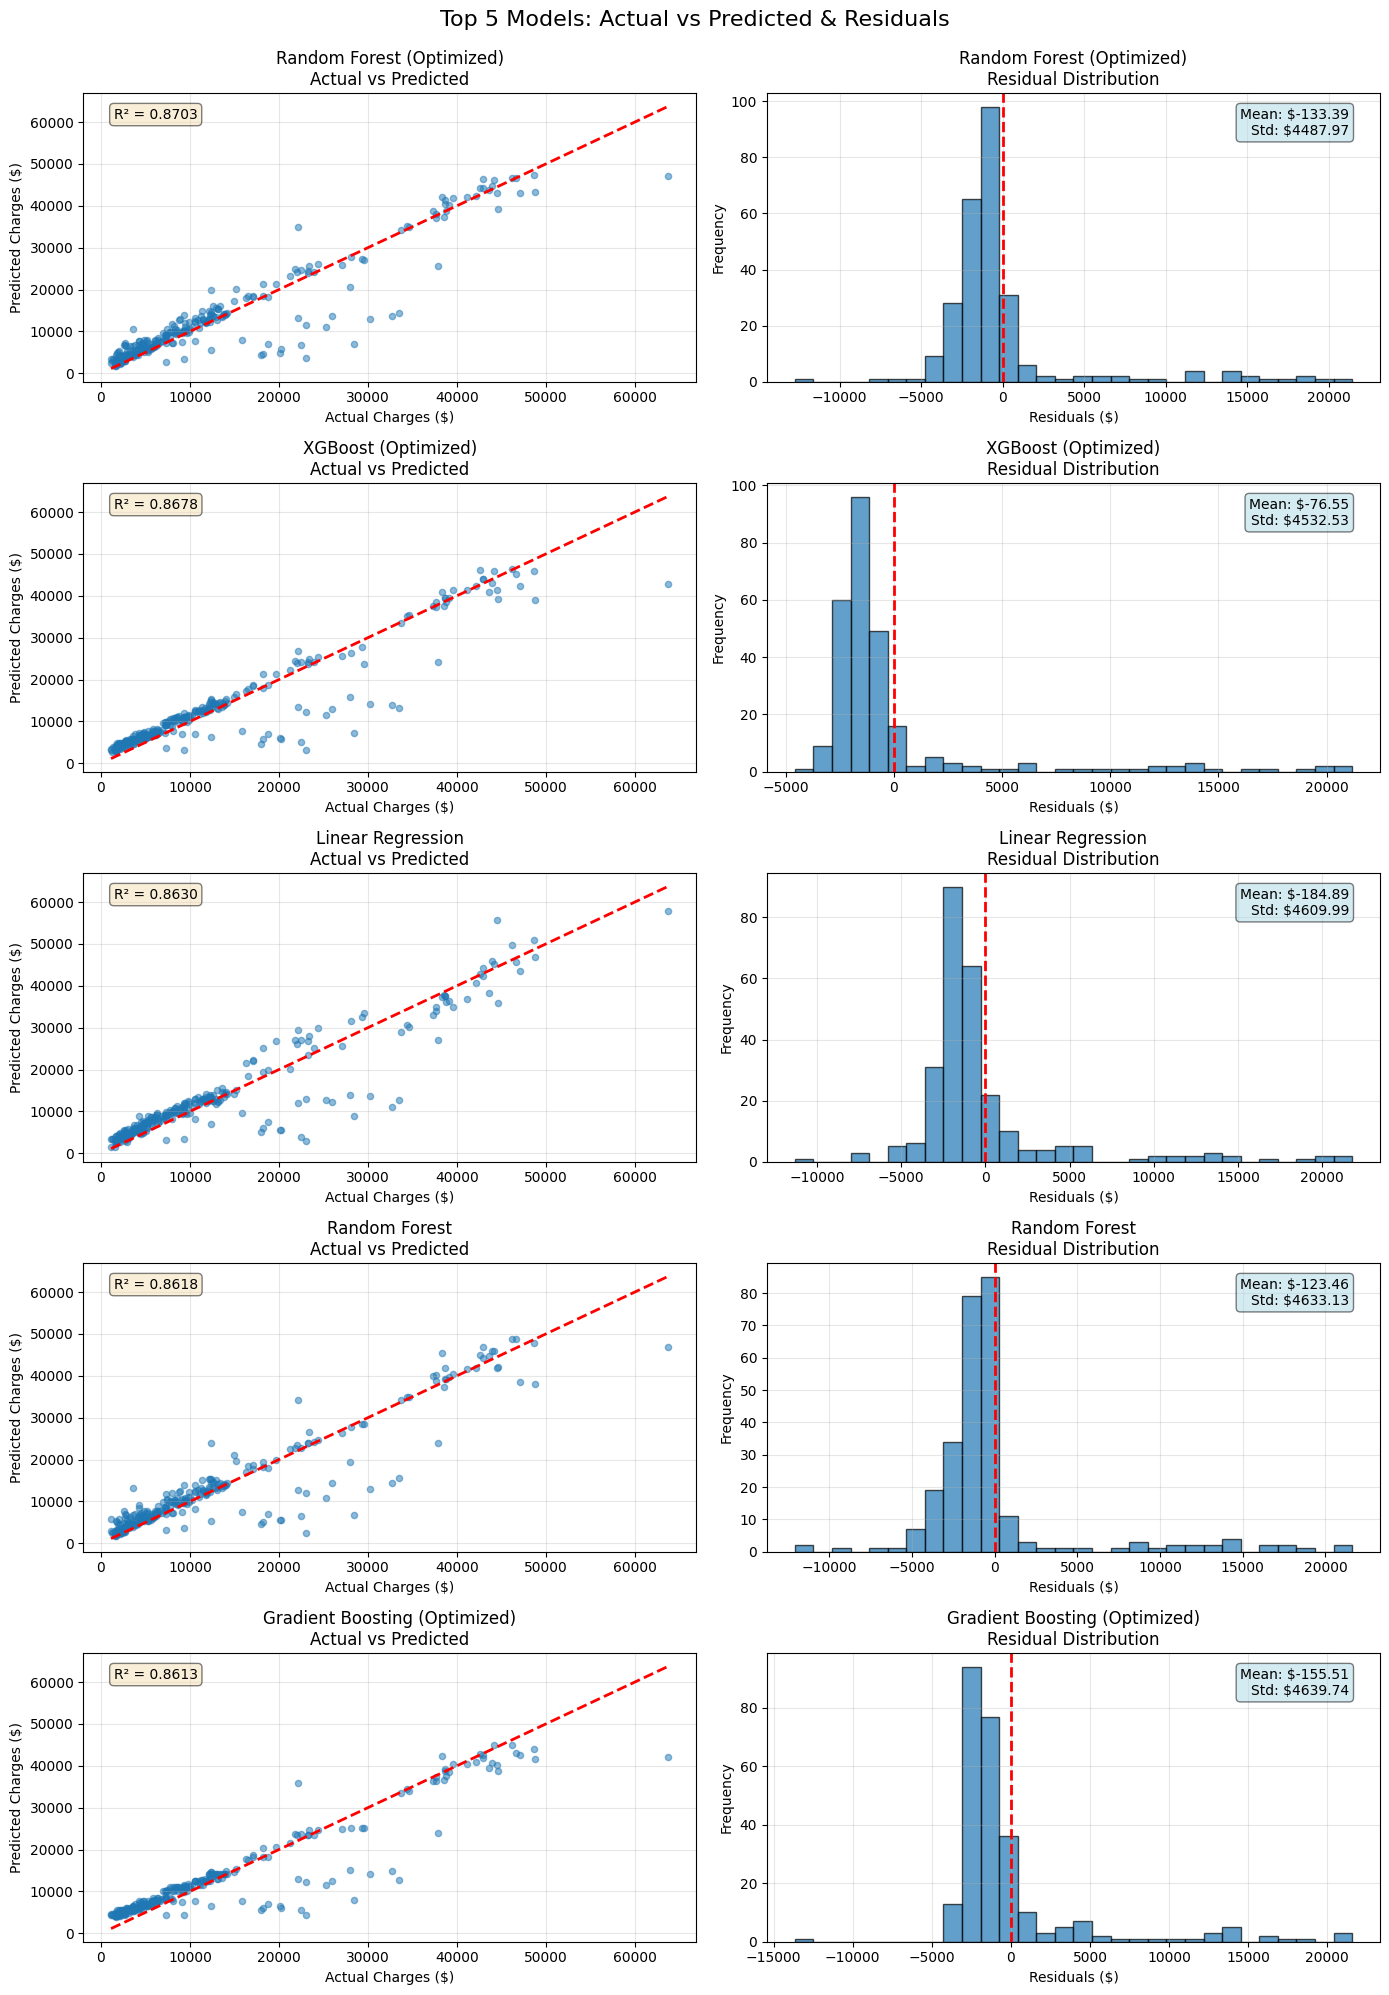


✓ Top 5 Models visualization completed!


In [30]:
# Plot Actual vs Predicted for Top 5 Models with Residuals
top_5_models = {
    'Random Forest (Optimized)': rf_grid.best_estimator_,
    'XGBoost (Optimized)': xgb_grid.best_estimator_,
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting (Optimized)': gb_grid.best_estimator_
}

fig, axes = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle('Top 5 Models: Actual vs Predicted & Residuals', fontsize=16, y=0.995)

for idx, (model_name, model) in enumerate(top_5_models.items()):
    # Make predictions
    if model_name == 'Linear Regression':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    residuals = y_test - y_pred
    
    # Plot Actual vs Predicted
    axes[idx, 0].scatter(y_test, y_pred, alpha=0.5, s=20)
    axes[idx, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx, 0].set_xlabel('Actual Charges ($)')
    axes[idx, 0].set_ylabel('Predicted Charges ($)')
    axes[idx, 0].set_title(f'{model_name}\nActual vs Predicted')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(y_test, y_pred)
    axes[idx, 0].text(0.05, 0.95, f'R² = {r2:.4f}', 
                      transform=axes[idx, 0].transAxes, 
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot Residuals
    axes[idx, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[idx, 1].set_xlabel('Residuals ($)')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].set_title(f'{model_name}\nResidual Distribution')
    axes[idx, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Add mean and std to residuals plot
    axes[idx, 1].text(0.95, 0.95, f'Mean: ${residuals.mean():.2f}\nStd: ${residuals.std():.2f}', 
                      transform=axes[idx, 1].transAxes, 
                      verticalalignment='top',
                      horizontalalignment='right',
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()

# Save the figure as PNG for the paper
plt.savefig('top5_models_predictions_residuals.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved as 'top5_models_predictions_residuals.png'")

plt.show()

print("\n✓ Top 5 Models visualization completed!")


## 11. Methodology Diagram